# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [18]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [19]:
# Read the Mapbox API key
load_dotenv()
mapbox_api = os.getenv("MAPBOX_API_KEY")
px.set_mapbox_access_token(mapbox_api)

# Import Data

In [68]:
# Import the necessary CSVs to Pandas DataFrames

census_df = pd.read_csv("sfo_neighborhoods_census_data.csv")
coords_df = pd.read_csv("sfo_neighborhoods_coordinates.csv", index_col='Neighborhood')


neighborhood_avgs = census_df.groupby('neighborhood').mean()
top_ten_expensive_neighborhoods = neighborhood_avgs['sale_price_sqr_foot'].sort_values(ascending=False)[:10]
    

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [75]:
# Define Panel Visualization Functions
def housing_units_per_year(census_df):
    """Housing Units Per Year."""
    
    housing_units_per_year_df = census_df.groupby('year')['housing_units'].mean()
    
    house_std = housing_units_per_year_df.std()
    house_plot_min = housing_units_per_year_df.min() - house_std
    house_plot_max = housing_units_per_year_df.max() + house_std

    housing_units_per_year_plot = housing_units_per_year_df.plot.bar(ylim=(house_plot_min,house_plot_max),title="Average Housing Units Sold in San Francisco (2010 - 2016)",xlabel="Year",ylabel="Housing Units")

    return housing_units_per_year_plot

def average_gross_rent(census_df):
    """Average Gross Rent in San Francisco Per Year."""
    
    average_gross_rent_df = census_df.groupby('year')['gross_rent'].mean()
    average_gross_rent_plot = average_gross_rent_df.plot(title="Average San Francisco Rent (2010 - 2016)",xlabel="Year",ylabel="Average Rent ($USD)")

    return average_gross_rent_plot



def average_sales_price(census_df):
    """Average Sales Price Per Year."""
    
    avg_sales_price_df = census_df.groupby('year')['sale_price_sqr_foot'].mean()
    avg_sales_price_plot = avg_sales_price_df.plot(title="Average Price per ft^2 San Francisco Homes Sold 2010 - 2016",xlabel="Year",ylabel="Price per ft^2 ($USD)")

    return avg_sales_price_plot



def average_price_by_neighborhood(census_df):
    """Average Prices by Neighborhood."""
    sfo_avg_price = census_df.groupby('year')['sale_price_sqr_foot'].mean()
    average_price_by_neighborhood_df = census_df.groupby(['year','neighborhood'])['sale_price_sqr_foot'].mean()
    avgerage_price_byb_neighborhood_plot = average_price_by_neighborhood_df.hvplot.line(title="Average Home Sale Price per Square Foot",groupby='neighborhood',label='neighborhood') * sfo_avg_price.hvplot.line(label="San Francisco")
    return avgerage_price_byb_neighborhood_plot



def top_most_expensive_neighborhoods(census_df):
    """Top 10 Most Expensive Neighborhoods."""

    avg_price_by_nbd_year = census_df.groupby(['year','neighborhood'])['sale_price_sqr_foot'].mean()
    top_most_expensive_by_year = avg_price_by_nbd_year.reset_index()
    top_most_expensive_by_year = top_most_expensive_by_year[top_most_expensive_by_year['neighborhood'].isin(top_ten_expensive_neighborhoods.index)]

    top_most_expensive_by_year_plot = top_most_expensive_by_year.hvplot.bar(
        x='year',
        groupby='neighborhood',
        title="Most Expensive San Francisco Neighborhoods to Buy Homes",
        xlabel="year",ylabel="home price per sq ft ($USD)",
        stacked=False, rot=90, height=500
    )

    return top_most_expensive_by_year_plot

def most_expensive_neighborhoods_rent_sales(census_df):
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    
    top_prices_plot = top_most_expensive_neighborhoods(census_df)

    avg_rent_by_nbd_year = census_df.groupby(['year','neighborhood'])['gross_rent'].mean()
    top_most_expensive_by_year = avg_rent_by_nbd_year.reset_index()
    top_most_expensive_by_year = top_most_expensive_by_year[top_most_expensive_by_year['neighborhood'].isin(top_ten_expensive_neighborhoods.index)]

    top_gross_rent_plot = top_most_expensive_by_year.hvplot.bar(
        x='year',
        groupby='neighborhood',
        title="Most Expensive San Francisco Neighborhoods to Rent",
        xlabel="year",ylabel="gross rent ($USD)",
        stacked=False, rot=90, height=500
    )

    most_expensive_neighborhoods_rent_sales_plot = top_prices_plot + top_gross_rent_plot
    return most_expensive_neighborhoods_rent_sales_plot
    
    
def parallel_coordinates(census_df):
    """Parallel Coordinates Plot."""

    sfo_grouped = census_df.groupby(['year','neighborhood']).mean()
    sfo_grouped.reset_index(inplace=True)

    most_expensive_df = sfo_grouped[sfo_grouped['neighborhood'].isin(top_ten_expensive_neighborhoods.index)]

    most_expensive_avg = most_expensive_df.groupby('neighborhood').mean()
    most_expensive_avg.reset_index(inplace=True)
    most_expensive_avg.sort_values('sale_price_sqr_foot',ascending=False,inplace=True)

    parallel_coordinates_plot = px.parallel_coordinates(most_expensive_avg,
        dimensions=['sale_price_sqr_foot','housing_units','gross_rent'],
        color='sale_price_sqr_foot',
        labels={
            "housing_units":"housing units",
            "sale_price_sqr_foot":"price per square foot",
            "gross_rent":"gross rent",
        },
    )

    return parallel_coordinates_plot

def parallel_categories(census_df):
    """Parallel Categories Plot."""
    
    sfo_grouped = census_df.groupby(['year','neighborhood']).mean()
    sfo_grouped.reset_index(inplace=True)

    most_expensive_df = sfo_grouped[sfo_grouped['neighborhood'].isin(top_ten_expensive_neighborhoods.index)]

    most_expensive_avg = most_expensive_df.groupby('neighborhood').mean()
    most_expensive_avg.reset_index(inplace=True)
    most_expensive_avg.sort_values('sale_price_sqr_foot',ascending=False,inplace=True)

    parallel_categories_plot = px.parallel_categories(
        most_expensive_avg,
        dimensions=['neighborhood','sale_price_sqr_foot','housing_units','gross_rent'],
        color='sale_price_sqr_foot',
        color_continuous_scale=px.colors.sequential.Inferno,
        labels={
            "neighborhood":"neighborhood",
            "sale_price_sqr_foot":"price per square foot",
            "housing_units":"housing units",
            "gross_rent":"gross rent",
        },
    )

    return parallel_categories_plot



def neighborhood_map(coords_df):
    """Neighborhood Map."""

    neighborhood_map_df = pd.concat([neighborhood_avgs,coords_df],axis='columns',join='inner')
    neighborhood_map_df.index.rename('neighborhood',inplace=True)
    neighborhood_map_df.reset_index(inplace=True)
    
    neighborhood_mapbox_plot = px.scatter_mapbox(neighborhood_map_df,lat='Lat',lon='Lon',size='sale_price_sqr_foot',color='neighborhood',hover_data=['neighborhood','sale_price_sqr_foot','gross_rent'],zoom=10)

    return neighborhood_mapbox_plot


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [ ]:
# Create a Title for the Dashboard
dash_title = 'San Francisco Housing Data'


# Create a tab layout for the dashboard

units_price_rent = pn.Column('## Housing Units, Average Home Price, and Average Rent',
    housing_units_per_year(census_df),
    average_gross_rent(census_df),
    average_sales_price(census_df)
)

neighborhood_data = pn.Column('## Neighborhood Data',
    average_price_by_neighborhood(census_df),
    top_most_expensive_neighborhoods(census_df),
    most_expensive_neighborhoods_rent_sales(census_df),
)

map_tab = pn.Column('## Neighborhood Map', neighborhood_map(coords_df))

parallel_plots = pn.Column(' ## Housing Data Parallels',
    parallel_coordinates(census_df),
    parallel_categories(census_df)
)


# Create the dashboard
sfo_dashboard = pn.Tabs(
    ('Units/Price/Rent', units_price_rent), 
    ('By Neighborhood', neighborhood_data), 
    ('Parallels', parallel_plots), 
    ('Map', map_tab)
)

## Serve the Panel Dashboard

In [ ]:
# Serve the dashboard
sfo_dashboard.servable(title=dash_title)

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

<AxesSubplot:title={'center':'Average Housing Units Sold in San Francisco (2010 - 2016)'}, xlabel='Year', ylabel='Housing Units'>

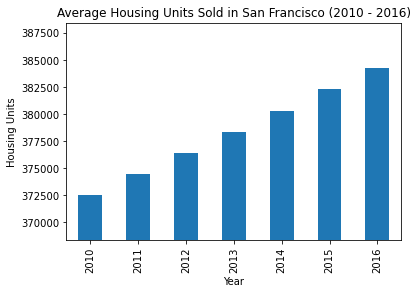

In [78]:
# housing_units_per_year()
housing_units_per_year(census_df)

<AxesSubplot:title={'center':'Average San Francisco Rent (2010 - 2016)'}, xlabel='Year', ylabel='Average Rent ($USD)'>

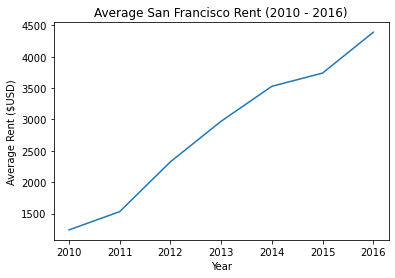

In [79]:
# average_gross_rent()
average_gross_rent(census_df)

<AxesSubplot:title={'center':'Average Price per ft^2 San Francisco Homes Sold 2010 - 2016'}, xlabel='Year', ylabel='Price per ft^2 ($USD)'>

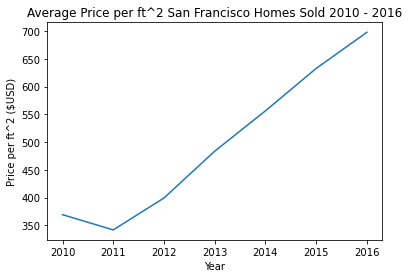

In [80]:
# average_sales_price()
average_sales_price(census_df)

In [81]:
# average_price_by_neighborhood()
average_price_by_neighborhood(census_df)

BokehModel(combine_events=True, render_bundle={'docs_json': {'497594a7-cc1e-44a5-ab61-41fe05c66f15': {'defs': …

:DynamicMap   [neighborhood]
   :Overlay
      .Curve.Neighborhood  :Curve   [year]   (sale_price_sqr_foot)
      .Curve.San_Francisco :Curve   [year]   (sale_price_sqr_foot)

In [82]:
# top_most_expensive_neighborhoods()
top_most_expensive_neighborhoods(census_df)

BokehModel(combine_events=True, render_bundle={'docs_json': {'42c8409a-f5e6-49b4-9bf1-3f5541b4583b': {'defs': …

:DynamicMap   [neighborhood]
   :Bars   [year]   (sale_price_sqr_foot)

In [83]:
# most_expensive_neighborhoods_rent_sales()
most_expensive_neighborhoods_rent_sales(census_df)

BokehModel(combine_events=True, render_bundle={'docs_json': {'3779e39f-e092-4a4b-a38c-94c2295be88f': {'defs': …

:Layout
   .DynamicMap.I  :DynamicMap   [neighborhood]
      :Bars   [year]   (sale_price_sqr_foot)
   .DynamicMap.II :DynamicMap   [neighborhood]
      :Bars   [year]   (gross_rent)

In [84]:
# neighborhood_map()
neighborhood_map(coords_df)

In [85]:
# parallel_categories()
parallel_categories(census_df)

In [86]:
# parallel_coordinates()
parallel_coordinates(census_df)